## Neural network for pax prediction

In [1]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Add, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [3]:
df = pd.read_csv('Datasets/augmented_SRQ_data_v3.csv')
df = df.drop(columns='Unnamed: 0')
df

,Date,Flight,Destination Airport,Airline,Boarded,Day_of_Week,Month,Day_of_Month,Destination Airport_encoded,Airline_encoded,day_sin,day_cos,month_sin,month_cos,dow_sin,dow_cos,route_mean,route_median,route_std
0,2023-09-14,AA2679,DFW,AA,130,3,9,14,23,0,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,96.518750,99.5,51.749150
1,2023-09-14,G41150,PIT,G4,155,3,9,14,60,5,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,148.430034,162.0,34.409989
2,2023-09-14,G4183,ABE,G4,152,3,9,14,0,5,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,150.730769,157.0,23.763546
3,2023-09-14,G4218,AVL,G4,144,3,9,14,6,5,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,126.549550,133.5,33.820457
4,2023-09-14,G42977,CAK,G4,143,3,9,14,14,5,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,152.762452,160.0,22.801929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12555,2025-07-20,WN4409,IND,WN,71,6,7,20,40,9,-0.790776,-0.612106,1.224647e-16,-1.0,-0.781831,0.623490,105.357143,111.0,35.060103
12556,2025-07-20,WN4605,MDW,WN,125,6,7,20,49,9,-0.790776,-0.612106,1.224647e-16,-1.0,-0.781831,0.623490,120.400000,122.0,39.266401
12557,2025-07-20,WN4606,STL,WN,75,6,7,20,71,9,-0.790776,-0.612106,1.224647e-16,-1.0,-0.781831,0.623490,119.448980,128.0,35.404741
12558,2025-07-20,XP306,HVN,XP,132,6,7,20,36,10,-0.790776,-0.612106,1.224647e-16,-1.0,-0.781831,0.623490,121.601604,129.0,37.176401


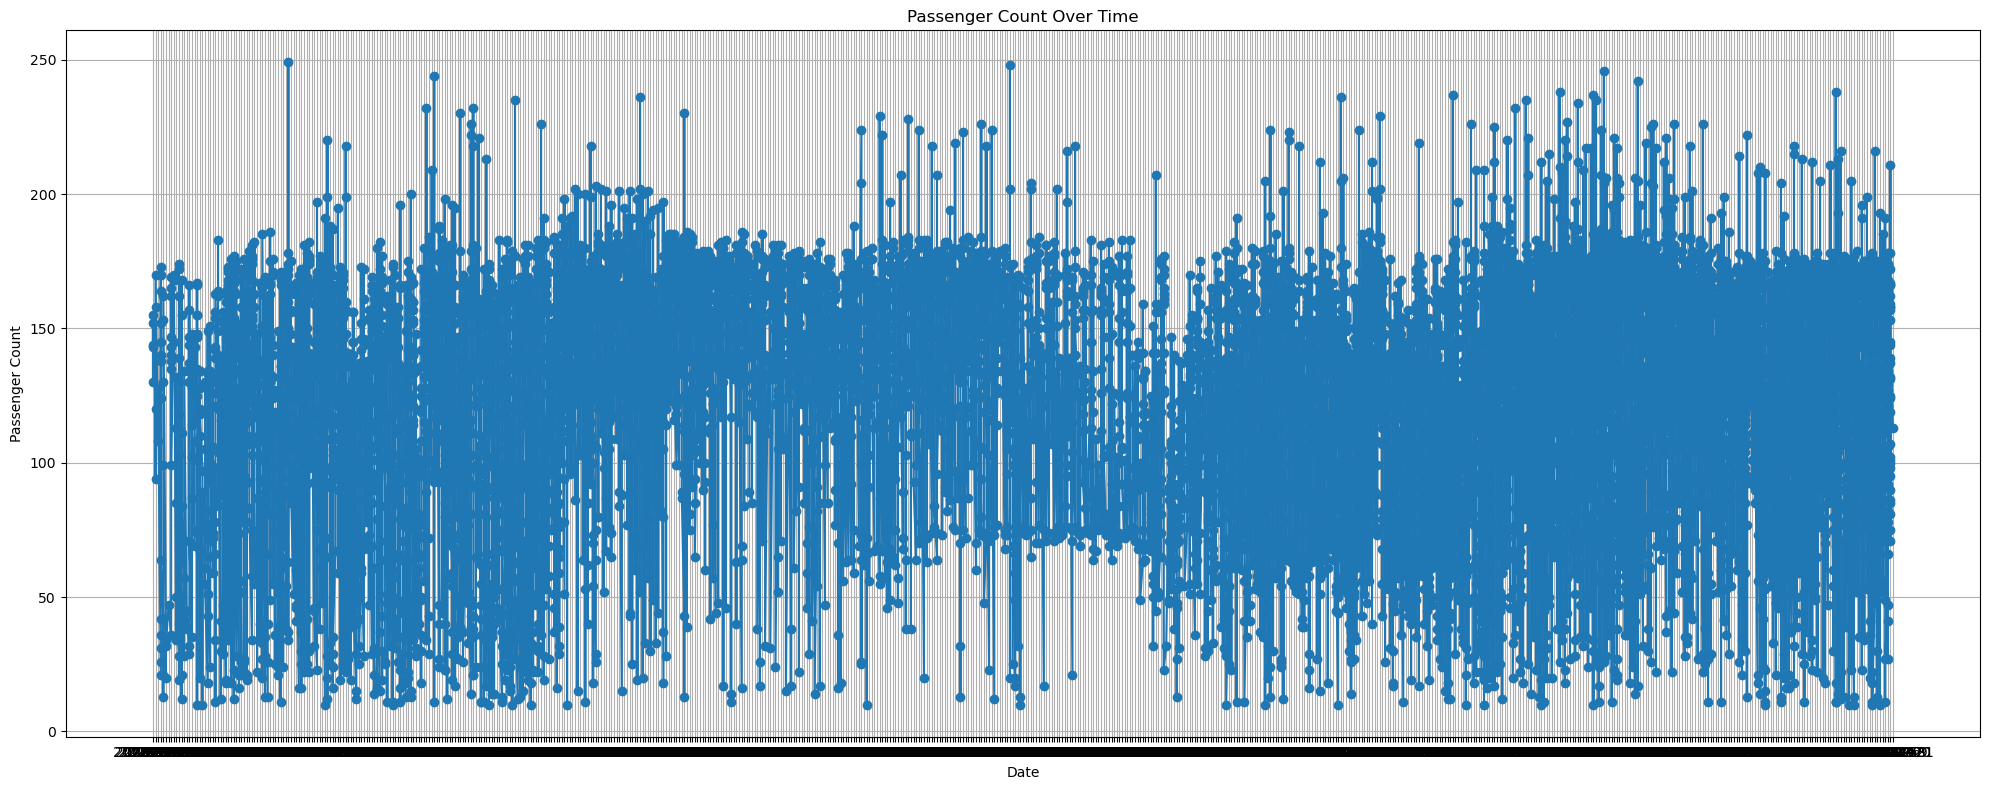

In [4]:
plt.figure(figsize=(20,8))
plt.plot(df['Date'], df['Boarded'], marker='o', linestyle='-')
plt.title('Passenger Count Over Time')
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
feature_columns = [  'Destination Airport_encoded', 'Airline_encoded',
    #'Day_of_Week', 'Month', 'Day_of_Month', 
    'day_sin',  'month_sin', 'dow_sin',
    'day_cos', 'month_cos', 'dow_cos', 
    'route_mean', 'route_median', 'route_std',]

In [6]:

X = df[feature_columns]
y = df['Boarded']  # or whatever your target column is
dates = pd.to_datetime(df['Date'])


split_index = int(len(df) * 0.8)

# Split data chronologically
X_train = X.iloc[:split_index]
#X_test = X.iloc[split_index:]
X_test = X_train

y_train = y.iloc[:split_index]
#y_test = y.iloc[split_index:]
y_test = y_train

dates_train = dates.iloc[:split_index]
dates_test = dates.iloc[split_index:]

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Training target range: {y_train.min()} to {y_train.max()}")
print(f"Testing target range: {y_test.min()} to {y_test.max()}")

Training set size: 10048
Testing set size: 10048
Training target range: 10 to 249
Testing target range: 10 to 249


In [7]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

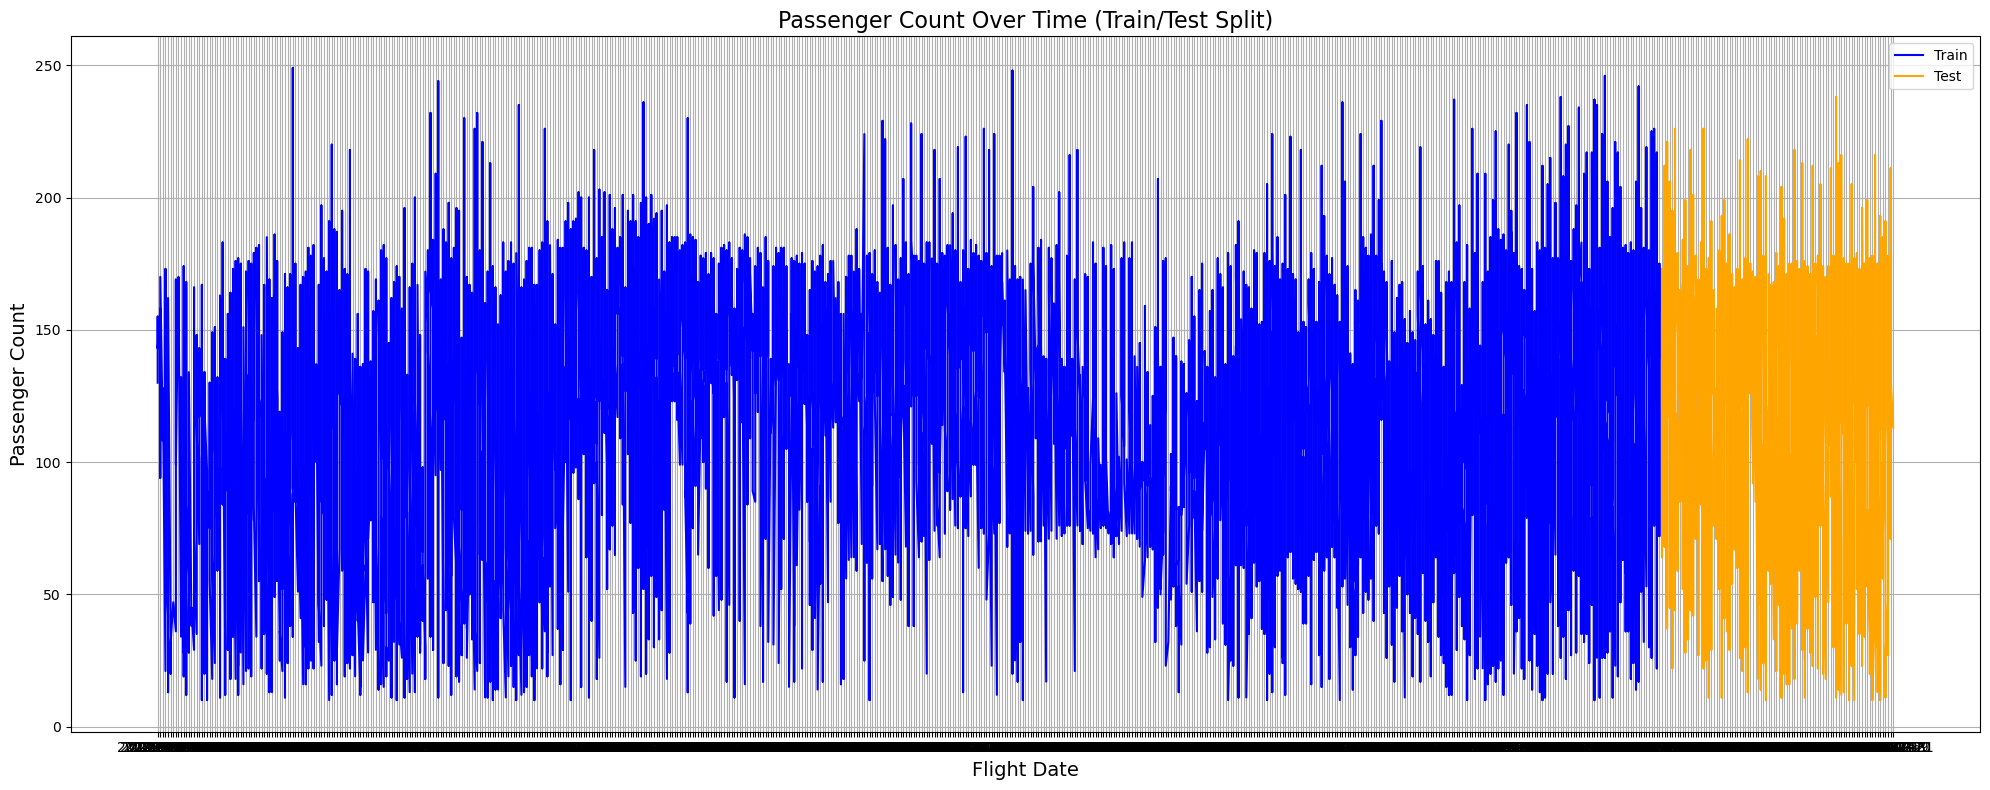

In [8]:
# Get the split index (number of training samples)
split_index = len(y_train)

# Extract date and passenger count
df_timestamps = df['Date']
passenger_counts = df['Boarded']

# Plot
plt.figure(figsize=(20, 8))

plt.plot(df_timestamps[:split_index], passenger_counts[:split_index], label='Train', color='blue')
plt.plot(df_timestamps[split_index:], passenger_counts[split_index:], label='Test', color='orange')

plt.title('Passenger Count Over Time (Train/Test Split)', fontsize=16)
plt.xlabel('Flight Date', fontsize=14)
plt.ylabel('Passenger Count', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
from tensorflow.keras.callbacks import LearningRateScheduler
 
# Define scheduler function
def scheduler(epoch, lr):
    if epoch%10 != 0:
        return lr
    else:
        return lr * 0.925  # decay by 10%
 
lr_callback = LearningRateScheduler(scheduler)

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(11,)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear'),    
])

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae', 'mse']
             )


# def residual_block(x, units, dropout_rate=0.2, l2_reg=1e-4):
#     #add regularisation or dropout back on full dataset
#     res = x
#     x = Dense(units)(x)
#     x = Activation('relu')(x)
#     x = Dense(units)(x)
#     # Residual connection
#     x = Add()([x, res])
#     x = Activation('relu')(x)
#     return x
 
# # Input layer
# inputs = Input(shape=(11,))
# x = Dense(1024, activation='relu')(inputs)
 
# # Residual blocks
# x = residual_block(x, 1024)
# x = residual_block(x, 1024)
# x = residual_block(x, 1024)
# x = residual_block(x, 1024)
# x = residual_block(x, 1024)
# x = residual_block(x, 1024)
 
# # Final layers
# x = Dense(128, activation='relu')(x)
# x = Dense(64, activation='relu')(x)
 
# # Output layer
# output = Dense(1, activation='linear')(x)  # use 'sigmoid' for binary classification
 
# # Model
# model = Model(inputs=inputs, outputs=output)
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


C:\Users\KamarioSinclair\.conda\envs\pax-prediction\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │        12,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,449,409 (24.60 MB)

 Trainable params: 6,449,409 (24.60 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# For validation during training, use chronological split within training data
# Take last 20% of training data as validation set
val_split_index = int(len(X_train) * 0.8)

X_train_final = X_train_scaled[:val_split_index]
X_val = X_train_scaled[val_split_index:]
y_train_final = y_train.iloc[:val_split_index]
y_val = y_train.iloc[val_split_index:]

print("NaNs in X_val:", np.isnan(X_val).sum())
print("NaNs in y_val:", np.isnan(y_val).sum())

# Check for infinities
print("Infs in X_val:", np.isinf(X_val).sum())
print("Infs in y_val:", np.isinf(y_val).sum())

NaNs in X_val: 3
NaNs in y_val: 0
Infs in X_val: 0
Infs in y_val: 0


In [12]:
history = model.fit(X_train_final, y_train_final,
                    epochs=200,
                    batch_size=128,
                    validation_data=(X_val, y_val),  # or use x_test/y_test for validation if you prefer
                    verbose=1,
                    callbacks=[lr_callback])

Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 6966.7734 - mae: 68.3431 - mse: 6966.7734 - val_loss: 1735.0714 - val_mae: 32.9382 - val_mse: 1735.0714 - learning_rate: 9.2500e-04
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 1934.0044 - mae: 36.1198 - mse: 1934.0044 - val_loss: 1705.0658 - val_mae: 33.6106 - val_mse: 1705.0658 - learning_rate: 9.2500e-04
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 1907.0587 - mae: 35.8788 - mse: 1907.0587 - val_loss: 1773.4397 - val_mae: 34.7211 - val_mse: 1773.4397 - learning_rate: 9.2500e-04
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 1913.5767 - mae: 35.9799 - mse: 1913.5767 - val_loss: 1794.9789 - val_mae: 35.0175 - val_mse: 1794.9789 - learning_rate: 9.2500e-04
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 1920.1918 - mae: 36.0687 - mse: 1920.1918 - val_loss: 1794.9296 - val_mae: 35.0168 - val_mse: 1794.9296 - learning_rate: 9.2500e-04
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 7

In [13]:
output = model.evaluate(X_test_scaled, y_test, verbose=1)
print(output)

314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1855.2002 - mae: 35.3610 - mse: 1855.2002
[1855.2001953125, 35.36099624633789, 1855.2001953125]


In [14]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(10048, 11) (10048,)
(10048, 11) (10048,)


In [15]:
# Generate predictions

y_pred = model.predict(X_test_scaled)
y_true = y_test.values

314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


(array([20201. , 20201.5, 20202. , 20202.5, 20203. , 20203.5, 20204. ]),
 [Text(20201.0, 0, '04-23 00'),
  Text(20201.5, 0, '04-23 12'),
  Text(20202.0, 0, '04-24 00'),
  Text(20202.5, 0, '04-24 12'),
  Text(20203.0, 0, '04-25 00'),
  Text(20203.5, 0, '04-25 12'),
  Text(20204.0, 0, '04-26 00')])

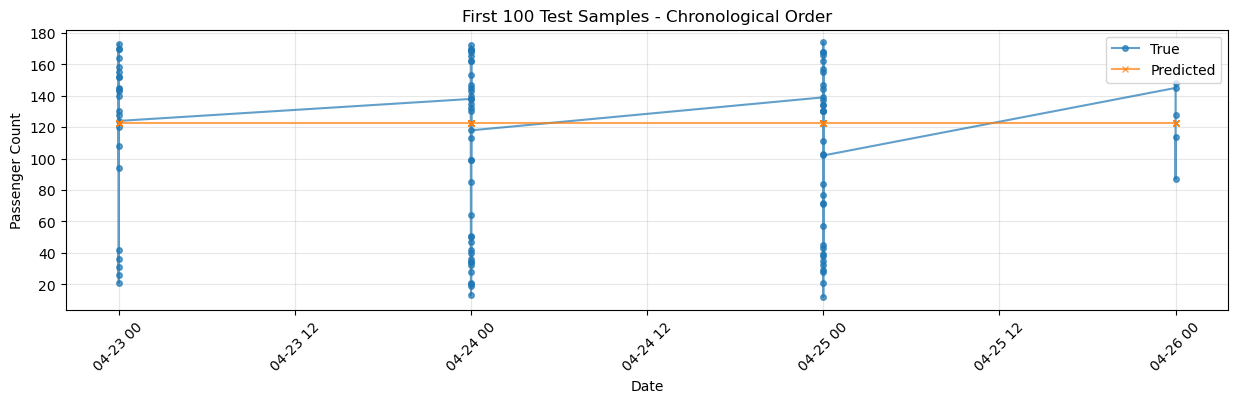

In [16]:
# Plot predictions vs actual - now dates align correctly
plt.figure(figsize=(15, 8))

# Plot first 100 test samples
n_samples = min(100, len(y_test))
dates_plot = dates_test.iloc[:n_samples]
y_true_plot = y_true[:n_samples]
y_pred_plot = y_pred[:n_samples]

plt.subplot(2, 1, 1)
plt.plot(dates_plot, y_true_plot, label='True', marker='o', alpha=0.7, markersize=4)
plt.plot(dates_plot, y_pred_plot, label='Predicted', marker='x', alpha=0.7, markersize=4)
plt.title('First 100 Test Samples - Chronological Order')
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)


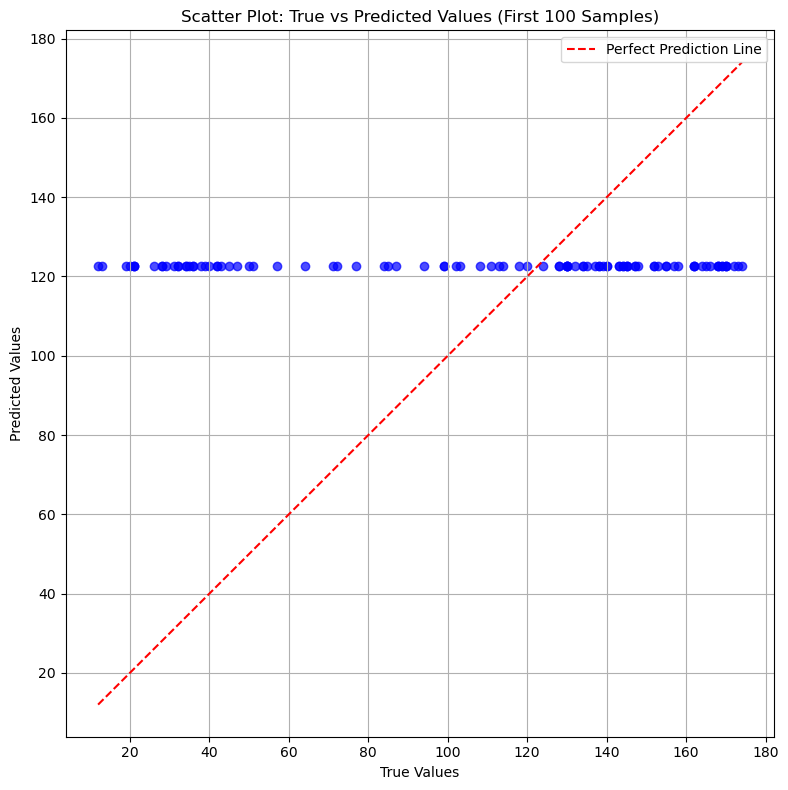

In [17]:

# First 100 samples
y_true_100 = y_true[:100]
y_pred_100 = y_pred[:100].flatten()

# Scatter plot: True vs Predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_true_plot, y_pred_plot, color='blue', alpha=0.7)
plt.plot([y_true_plot.min(), y_true_plot.max()],
         [y_true_plot.min(), y_true_plot.max()],
         color='red', linestyle='--', label='Perfect Prediction Line')

plt.title('Scatter Plot: True vs Predicted Values (First 100 Samples)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

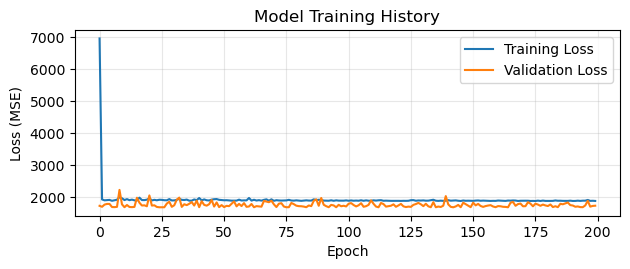

In [18]:
# Plot training history
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# Check your data preprocessing first
print("Data diagnostics:")
print(f"X_train shape: {X_train_scaled.shape}")
print(f"Feature statistics after scaling:")
print(f"Mean: {X_train_scaled.mean(axis=0)}")
print(f"Std: {X_train_scaled.std(axis=0)}")
print(f"Y_train_log statistics:")
print(f"Mean: {y_train.mean():.3f}, Std: {y_train.std():.3f}")
print(f"Min: {y_train.min():.3f}, Max: {y_train.max():.3f}")

Data diagnostics:
X_train shape: (10048, 11)
Feature statistics after scaling:
Mean: [ 2.82859369e-18  5.65718739e-18  6.78862486e-17  0.00000000e+00
 -9.90007793e-18  1.41429685e-17  5.09146865e-17 -8.48578108e-18
  2.40430464e-16 -1.13143748e-17             nan]
Std: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. nan]
Y_train_log statistics:
Mean: 123.664, Std: 43.059
Min: 10.000, Max: 249.000
